In [1]:
!pip install -q gdown gensim

In [2]:
# import
import tarfile
import pandas as pd
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Bidirectional,LSTM, Input, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

## Load Dataset, Data Understanding and preprocessing

In [4]:
file_id = '0Bz8a_Dbh9QhbZVhsUnRWRDhETzA'
output_name = 'amazon_review_full_csv.tar.gz'

!gdown --id {file_id} -O {output_name}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA
From (redirected): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA&confirm=t&uuid=51f09ee6-2645-4c36-8022-983286f5152f
To: /content/amazon_review_full_csv.tar.gz
100% 644M/644M [00:04<00:00, 141MB/s]


In [5]:
# extract the .tar.gz
with tarfile.open(output_name, "r:gz") as tar:
    tar.extractall("Dataset")


!ls -R Dataset

Dataset:
amazon_review_full_csv

Dataset/amazon_review_full_csv:
readme.txt  test.csv  train.csv


In [6]:
# Set options to show full text and all rows
pd.set_option('display.max_colwidth', None)

df_train = pd.read_csv(
    './Dataset/amazon_review_full_csv/train.csv',
    header=None,
    names=['label', 'title', 'text'],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  # Skip rows with parsing errors
)

df_train.head()

,label,title,text
0,3,more like funchuck,"Gave this to my dad for a gag gift after directing ""Nunsense,"" he got a reall kick out of it!"
1,5,Inspiring,"I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature."
2,5,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."
3,4,Chrono Cross OST,"The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World""."
4,5,Too good to be true,Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999746 entries, 0 to 2999745
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   int64 
 1   title   object
 2   text    object
dtypes: int64(1), object(2)
memory usage: 68.7+ MB


In [8]:
# Show total null values in each column
df_train.isnull().sum()

,0
label,0
title,188
text,0


In [9]:
# see the rows that contains Null values
df_train[df_train.isnull().any(axis=1)]

,label,title,text
5985,5,NaN,"I am reading this book in 7th grade advanced language arts. Most students don't like it and think that it's confusing, but i love it."
10849,2,NaN,Couldn't get the device to work with my network so it just sits there useless.Vendor exceeded delivery expectations!
21999,2,NaN,"What separates this band from Evanescence (besides geography-these guys are from Slovenia) is mainly the structural song arrangements, the inclusion of a violin, and a few industrial/progressive/gothic parts. Otherwise, you'd swear this is Evanescence's experimental follow-up album. But in the end this is Melodic Hard Rock with many catchy hooks/choruses and songs that could easily be played on the radio. The role of the violin here is just as vital as the role of a guitar, dominating throughout the record and enhancing the music. Without it, this record would probably be extremely unoriginal. Basic, yet energetic female vocals keep the flow of the music listenable. There are some brilliant musical passages like in the song ""Shut Up"" (1:46-2:14), as well as silly male verbal chants (like on ""Blah Blah"" 2:56-3:10), but overall the harmlessness and accessibility of the material is enough to satisfy the open-minded ear."
26818,3,NaN,"Upon an initial glance at one passage (immediately after downloading this volume) I find that it is not completely devoid of the Greek, as another review might lead you to believe. However, it is an abridged edition, containing less information than my hardcover 6 volume set. Overall, I expect it to be a handy quick-reference that will give some insight without too much detail."
33679,3,NaN,Although this is an interesting book to browse it has not worked well as a reference source for college studies. Searches for what I consider to be common ecological terms and concepts usually end up with no results found. Perhaps the book is not intended as a reference manual.
...,...,...,...
2877965,5,NaN,"I've been using this mouse pad for a little over a month now, and there's no other way to describe it except 'superb'. Or I guess you could insert your personal favorite superlative. 'excellent' also works nicely.Anyway, the mouse pad itself is actually just shy of being as big as my monitor (19""). So, you can have your sensitivity as low as you want and not ever. run out of room. Ever. Seriously. I personally like the control side the most - for some reason I just feel more... in control or my mouse. Compared to my generic cloth mouse pad that I've had for the past 3 computers , this thing makes it seem as though my mouse is levitating. (I'm using the razer copperhead mouse, by the way.)Oh, and the squishy wrist rest is sure to keep my wrist safe from carpal tunnel for good while. It's really quite comfortable.All jokes aside, this is definitely the best mouse pad I've ever owned. If you've never had anything but a cloth mouse pad (or no mouse pad) prepare to be amazed."
2955788,4,NaN,This book saved my sanity when my twins refused to sleep. They quickly got onto a sleep eat play routine and became happy instead of always cranky. However it doesnt work for all babies. My youngest just wasnt going for the routine. it took several months to find a smooth schedule for him. You dont have to follow this scientifically. take what works for you and find other resources as well.
2971464,2,NaN,IBD should sell single issues for the iPad to make a useable version available at a fair price!!!
2979783,2,NaN,I got on a short story kick after reading Jhumpa Lahari. This definitely is not of that calibar. Better luck next time.


In [10]:
# Check how many duplicate rows exist
df_train.duplicated().sum()

0

In [11]:
df_train['label'].value_counts(normalize=True) * 100

,proportion
label,
4,20.000493
5,20.000460
1,19.999860
3,19.999660
2,19.999527


In [12]:
# Number of rows
print("Number of rows:", len(df_train))

# Check for null values
if df_train.isnull().values.any():
    print("There are null elements in the DataFrame.")
else:
    print("There are no null elements in the DataFrame.")

Number of rows: 2999746
There are null elements in the DataFrame.


In [13]:
df_hold_out_test = pd.read_csv(
    './Dataset/amazon_review_full_csv/test.csv',
    header=None,
    names=['label', 'title', 'text'],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  # Skip rows with parsing errors
)

df_hold_out_test.head()


,label,title,text
0,1,mens ultrasheer,"This model may be ok for sedentary types, but I'm active and get around alot in my job - consistently found these stockings rolled up down by my ankles! Not Good!! Solution: go with the standard compression stocking, 20-30, stock #114622. Excellent support, stays up and gives me what I need. Both pair of these also tore as I struggled to pull them up all the time. Good riddance/bad investment!"
1,4,Surprisingly delightful,"This is a fast read filled with unexpected humour and profound insights into the art of politics and policy. In brief, it is sly, wry, and wise."
2,2,"Works, but not as advertised","I bought one of these chargers..the instructions say the lights stay on while the battery charges...true. The instructions doNT say the lights turn off when its done. Which is also true. 24 hours of charging and the lights stay on. I returned it thinking I had a bad unit.The new one did the same thing. I just kept it since it does charge...but the lights are useless since they seem to always stay on. It's a ""backup"" charger for when I manage to drain all my AAs but I wouldn't want this as my only charger."
3,2,Oh dear,"I was excited to find a book ostensibly about Muslim feminism, but this volume did not live up to the expectations.One essay, among other things, describes the veil as potentially liberating. It doesn't begin to explain how or why.Another, on Muslim women in Cape Town, claims that Muslim women there are separate but ""more than equal."" Gee whiz, what a disappointment.I had expected and hoped for at least one Muslim feminist condemnation of gender apartheid. But there is not a single one in the book.I'm surprised it didn't have an essay extolling the virtues of female genital mutilation.--Alyssa A. Lappen"
4,2,Incorrect disc!,"I am a big JVC fan, but I do not like this model, I was suspiscious when I saw several units in the return section of the store. I bought one anyway (new) and must say I am not happy. The unit sends out clicks to the receiver once in a while, the transition between scenes is not always smooth,(like a little pause) and while it is still fairly new I can't get any DVD,CD or even a DVD headcleaner to work. All I get is a ""incorrect disc"" message."


In [14]:
# Number of rows
print("Number of rows:", len(df_hold_out_test))

# Check for null values
if df_hold_out_test.isnull().values.any():
    print("There are null elements in the DataFrame.")
else:
    print("There are no null elements in the DataFrame.")

Number of rows: 649954
There are null elements in the DataFrame.


In [15]:
# Keep only positive (4,5) and negative (1,2) ratings
# throw away neutral reviews with rating = 3
df_train = df_train[df_train['label'] != 3].copy()

# Map ratings to binary sentiment
df_train['sentiment'] = df_train['label'].apply(lambda x: 1 if x > 3 else 0)

In [16]:
df_train['label'].value_counts()

,count
label,
4,599964
5,599963
1,599945
2,599935


In [17]:
df_train.head(10)

,label,title,text,sentiment
1,5,Inspiring,"I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature.",1
2,5,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",1
3,4,Chrono Cross OST,"The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World"".",1
4,5,Too good to be true,Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!,1
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even the version that's not an import.Some of the best music ever. I could listen to every track every minute of every day. That's about all i can say.",1
6,1,Buyer beware,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a ""worst book"" contest. I can't believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on ""To Kill a Mockingbird""--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!",0
7,4,"Errors, but great story","I was a dissapointed to see errors on the back cover, but since I paid for the book I read it anyway. I have to say I love it. I couldn't put it down. I read the whole book in two hours. I say buy it. I say read it. It is sad, but it gives an interesting point of view on church today. We spend too much time looking at the faults of others. I also enjoyed beloved.Sincerly,Jaylynn R",1
8,1,The Worst!,"A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book.",0
9,1,Oh please,"I guess you have to be a romance novel lover for this one, and not a very discerning one. All others beware! It is absolute drivel. I figured I was in trouble when a typo is prominently featured on the back cover, but the first page of the book removed all doubt. Wait - maybe I'm missing the point. A quick re-read of the beginning now makes it clear. This has to be an intentional churning of over-heated prose for satiric purposes. Phew, so glad I didn't waste $10.95 after all.",0
10,1,Awful beyond belief!,"I feel I have to write to keep others from wasting their money. This book seems to have been written by a 7th grader with poor grammatical skills for her age! As another reviewer points out, there is a misspelling on the cover, and I believe there is at l

In [18]:
# create the column review which is a concatenation of title + text
df_train['review'] = df_train['title'].fillna('') + ' ' + df_train['text'].fillna('')
df_train.head(10)

,label,title,text,sentiment,review
1,5,Inspiring,"I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature.",1,"Inspiring I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature."
2,5,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",1,"The best soundtrack ever to anything. I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."
3,4,Chrono Cross OST,"The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World"".",1,"Chrono Cross OST The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World""."
4,5,Too good to be true,Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!,1,Too good to be true Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even the version that's not an import.Some of the best music ever. I could listen to every track every minute of every day. That's about all i can say.",1,"There's a reason for the price There's a reason this CD is so expensive, even the version that's not an import.Some of the best music ever. I could listen to every track every minute of every day. That's about all i can say."
6,1,Buyer beware,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad eno

In [19]:
# here do a MINIMAL text preprocessing
# lowercasing and remove line breaks
df_train['review'] = df_train['review'].apply(lambda text: text.lower().replace('\n', ' '))
df_train.head(10)

,label,title,text,sentiment,review
1,5,Inspiring,"I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature.",1,"inspiring i hope a lot of people hear this cd. we need more strong and positive vibes like this. great vocals, fresh tunes, cross-cultural happiness. her blues is from the gut. the pop sounds are catchy and mature."
2,5,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",1,"the best soundtrack ever to anything. i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny."
3,4,Chrono Cross OST,"The music of Yasunori Misuda is without question my close second below the great Nobuo Uematsu.Chrono Cross OST is a wonderful creation filled with rich orchestra and synthesized sounds. While ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. Some of my favourite tracks include; ""Scars Left by Time, The Girl who Stole the Stars, and Another World"".",1,"chrono cross ost the music of yasunori misuda is without question my close second below the great nobuo uematsu.chrono cross ost is a wonderful creation filled with rich orchestra and synthesized sounds. while ambiance is one of the music's major factors, yet at times it's very uplifting and vigorous. some of my favourite tracks include; ""scars left by time, the girl who stole the stars, and another world""."
4,5,Too good to be true,Probably the greatest soundtrack in history! Usually it's better to have played the game first but this is so enjoyable anyway! I worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! Get this OST! it's amazing! The first few tracks will have you dancing around with delight (especially Scars Left by Time)!! BUY IT NOW!!,1,too good to be true probably the greatest soundtrack in history! usually it's better to have played the game first but this is so enjoyable anyway! i worked so hard getting this soundtrack and after spending [money] to get it it was really worth every penny!! get this ost! it's amazing! the first few tracks will have you dancing around with delight (especially scars left by time)!! buy it now!!
5,5,There's a reason for the price,"There's a reason this CD is so expensive, even the version that's not an import.Some of the best music ever. I could listen to every track every minute of every day. That's about all i can say.",1,"there's a reason for the price there's a reason this cd is so expensive, even the version that's not an import.some of the best music ever. i could listen to every track every minute of every day. that's about all i can say."
6,1,Buyer beware,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad eno

## Subsample and Splin Train vs Internal Test set

In [20]:
# subsample 1 milion Rows
df_train = df_train.sample(n=1_000_000, random_state=42)

X = df_train['review']
y = df_train['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps label distribution consistent
)

### Tokenization

In [21]:
# Set vocabulary size
max_words = 30000  # Only keep the 30,000 most common words

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

# fit the tokenizer on TR set
tokenizer.fit_on_texts(X_train)

# tokenize TR set
train_sequences = tokenizer.texts_to_sequences(X_train)
# tokenize TS set
test_sequences = tokenizer.texts_to_sequences(X_test)

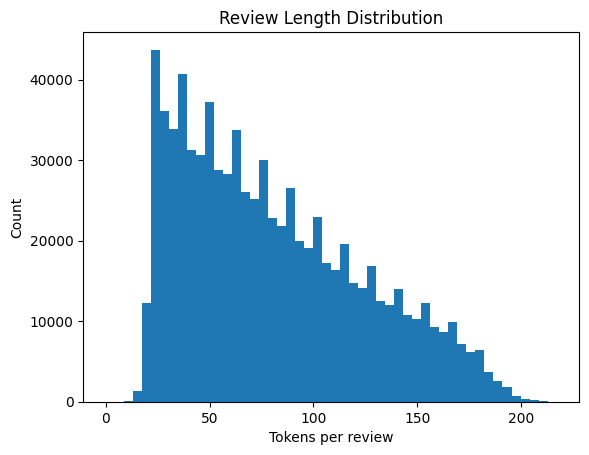

In [23]:
# analyzing review length distribution before padding
lengths = [len(seq) for seq in train_sequences]
plt.hist(lengths, bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Tokens per review")
plt.ylabel("Count")
plt.show()

In [24]:
print("95th percentile length:", np.percentile(lengths, 95))

95th percentile length: 164.0


In [25]:
max_len = 164      # set max review length in tokens

# pad train seq.
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len, padding='pre', truncating='pre')
# pad test seq.
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding='pre', truncating='pre')

In [26]:
import gdown
file_id = '1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy'
output_path = 'GoogleNews-vectors-negative300.bin'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output=output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy
From (redirected): https://drive.google.com/uc?id=1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy&confirm=t&uuid=96707dc8-262b-43ad-b969-a20c8bc9b90e
To: /content/GoogleNews-vectors-negative300.bin
100%|██████████| 3.64G/3.64G [00:32<00:00, 111MB/s]


'GoogleNews-vectors-negative300.bin'

In [27]:
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [28]:
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in w2v_model:
            embedding_matrix[i] = w2v_model[word]
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
model.fit(train_sequences_padded, y_train, epochs=5,
          validation_split=0.2, batch_size=64)

Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - accuracy: 0.8319 - loss: 0.3652 - val_accuracy: 0.9175 - val_loss: 0.2081
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - accuracy: 0.9219 - loss: 0.1963 - val_accuracy: 0.9302 - val_loss: 0.1796
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - accuracy: 0.9357 - loss: 0.1669 - val_accuracy: 0.9341 - val_loss: 0.1713
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - accuracy: 0.9440 - loss: 0.1488 - val_accuracy: 0.9367 - val_loss: 0.1672
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - accuracy: 0.9500 - loss: 0.1341 - val_accuracy: 0.9353 - val_loss: 0.1721


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(test_sequences_padded)
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     99934
           1       0.92      0.95      0.94    100066

    accuracy                           0.94    200000
   macro avg       0.94      0.94      0.94    200000
weighted avg       0.94      0.94      0.94    200000

Confusion Matrix:
[[91852  8082]
 [ 4830 95236]]
